Simple use the FFT to fit history tide data.  

Data from https://tidesandcurrents.noaa.gov/waterlevels.html?id=9414290&units=standard&bdate=20190701&edate=20190801&timezone=GMT&datum=MLLW&interval=6&action=data

In [1]:
import math
import datetime
import glob
import numpy
import pandas
import matplotlib.pyplot
import matplotlib.pylab
import seaborn
import sklearn.linear_model
import sklearn.metrics

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
base_date_time = datetime.datetime(2001, 1, 1)
first_date_time = datetime.datetime(2019, 6, 1)
cut_date_time = datetime.datetime(2019, 7, 15)

In [3]:
na_values = [ '', '-' ]
files = [f for f in glob.glob("tide_data/*.csv", recursive=False)]
files.sort()
tides = [pandas.read_csv(f, na_values=na_values) for f in files]
tides = pandas.concat(tides, axis=0)
tides.reset_index(inplace=True, drop=True)
tides.head()

,Date,Time (GMT),Predicted (ft),Preliminary (ft),Verified (ft)
0,2017/01/01,00:00,1.849,NaN,2.12
1,2017/01/01,00:06,1.695,NaN,1.97
2,2017/01/01,00:12,1.543,NaN,1.88
3,2017/01/01,00:18,1.393,NaN,1.78
4,2017/01/01,00:24,1.247,NaN,1.66


In [4]:
tides['dt'] = [datetime.datetime.strptime(tides['Date'][i] + ' ' + tides['Time (GMT)'][i], '%Y/%m/%d %H:%M') for i in range(tides.shape[0])]
tides = tides.loc[tides['dt']>=first_date_time, :]
tides.reset_index(inplace=True, drop=True)
tides['dts'] = [(t - base_date_time).total_seconds() for t in tides['dt']]
tides['train'] = tides['dt']<cut_date_time

In [5]:
tides.head()

,Date,Time (GMT),Predicted (ft),Preliminary (ft),Verified (ft),dt,dts,train
0,2019/06/01,00:00,2.118,NaN,2.44,2019-06-01 00:00:00,581040000.0,True
1,2019/06/01,00:06,2.171,NaN,2.50,2019-06-01 00:06:00,581040360.0,True
2,2019/06/01,00:12,2.227,NaN,2.55,2019-06-01 00:12:00,581040720.0,True
3,2019/06/01,00:18,2.288,NaN,2.60,2019-06-01 00:18:00,581041080.0,True
4,2019/06/01,00:24,2.352,NaN,2.68,2019-06-01 00:24:00,581041440.0,True


In [6]:
tides['tide feet'] = tides['Verified (ft)'].copy()
null_posns = pandas.isnull(tides['tide feet'])
tides.loc[null_posns, 'tide feet'] = tides.loc[null_posns, 'Preliminary (ft)']

In [7]:
numpy.mean(tides['tide feet'])

3.359842896174863

In [8]:
dtrain = tides.loc[tides['train'], :].copy()
dtrain.reset_index(inplace=True, drop=True)

In [9]:
xform = numpy.fft.fft(dtrain['tide feet'])

In [10]:
cutoff = 10**math.floor(numpy.log(-numpy.sort(-abs(xform))[20])/numpy.log(10))
cutoff

100

In [11]:
pick = abs(xform)>=cutoff
sum(pick)

91

In [12]:
xform[numpy.logical_not(pick)] = 0j

In [13]:
back = numpy.real(numpy.fft.ifft(xform))

In [14]:
dtrain['fft approx'] = back

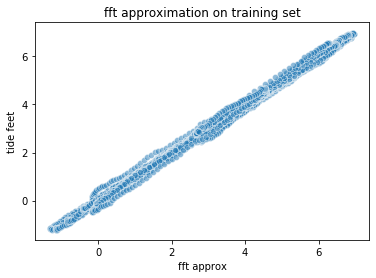

In [15]:
seaborn.scatterplot(x='fft approx', y='tide feet', 
                    data=dtrain, 
                    alpha=0.5)
info = matplotlib.pyplot.title("fft approximation on training set")

In [16]:
sklearn.metrics.r2_score(dtrain['tide feet'], dtrain['fft approx'])

0.9980771183967126

In [17]:
# freqs are defined as cycles per sample spacing
freqs = numpy.fft.fftfreq(dtrain.shape[0])
freqs = numpy.sort(numpy.unique([abs(f) for f in freqs[pick]]))
freqs = [f for f in freqs if f > 0]

In [18]:
sample_spacing_seconds = dtrain['dts'][1] - dtrain['dts'][0]

In [19]:
periods_seconds = [sample_spacing_seconds/f for f in freqs]

In [20]:
vars = []
for ps in periods_seconds:
    vs = 'sin(second/' + str(ps) + ')'
    dtrain[vs] = numpy.sin(2*numpy.pi*dtrain['dts']/ps)
    tides[vs] = numpy.sin(2*numpy.pi*tides['dts']/ps)
    vc = 'cos(second/' + str(ps) + ')'
    dtrain[vc] = numpy.cos(2*numpy.pi*dtrain['dts']/ps)
    tides[vc] = numpy.cos(2*numpy.pi*tides['dts']/ps)
    vars = vars + [vs, vc]
    

In [21]:
fitter = sklearn.linear_model.ElasticNet(fit_intercept=True, 
                                         alpha = 1e-4,
                                         max_iter=10000)
fitter.fit(dtrain[vars], dtrain['tide feet'])
#fitter.coef_

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=10000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [22]:
dtrain['predict'] = fitter.predict(dtrain[vars])

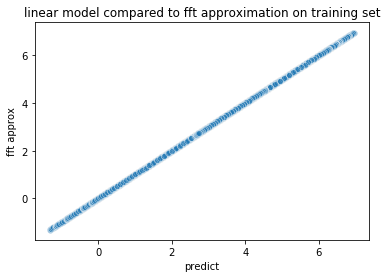

In [23]:
seaborn.scatterplot(x='predict', y='fft approx', 
                    data=dtrain, alpha=0.5)
info = matplotlib.pyplot.title("linear model compared to fft approximation on training set")

Note: can not extrapolate.  The prediction looks plausible,
but does not match actual. Time is shifted a bit, which makes predictions anti-correlate in this range.

In [24]:
tides['predict'] = fitter.predict(tides[vars])

In [25]:
dtest = tides.loc[numpy.logical_not(tides['train']), :].copy()
dtest.reset_index(inplace=True, drop=True)

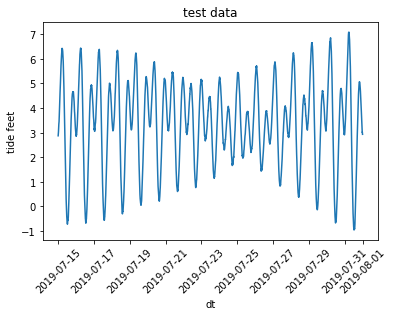

In [26]:
seaborn.lineplot(x='dt', y='tide feet', 
                 data=dtest)
info = matplotlib.pylab.xticks(rotation=45)
info = matplotlib.pyplot.title("test data")

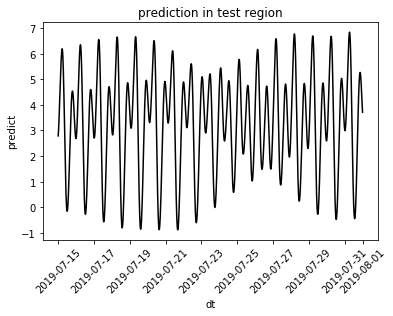

In [27]:
seaborn.lineplot(x='dt', y='predict', 
                 data=dtest, color='black')
info = matplotlib.pylab.xticks(rotation=45)
info = matplotlib.pyplot.title("prediction in test region")

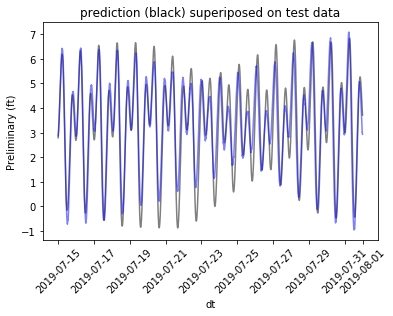

In [28]:
test_plot = tides.loc[numpy.logical_not(tides['train']), :]
seaborn.lineplot(x='dt', y='predict', 
                 data=test_plot,
                 color='black',
                 alpha=0.5)
seaborn.lineplot(x='dt', y='Preliminary (ft)', 
                 data=test_plot, 
                 color='blue',
                 alpha=0.5)
info = matplotlib.pylab.xticks(rotation=45)
info = matplotlib.pyplot.title("prediction (black) superiposed on test data")

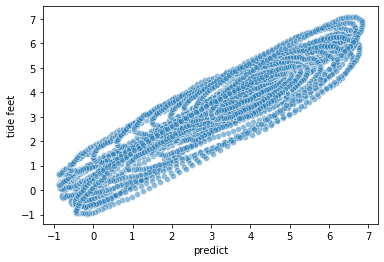

In [29]:
seaborn.scatterplot(x='predict', y='tide feet', 
                    data=dtest, 
                    alpha=0.5)

In [30]:
sklearn.metrics.r2_score(dtest['tide feet'], dtest['predict'])

0.8098615395692726